# Generate images for both human eyes and in silico

In [71]:
import function as df
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
import os
import bz2
import math
import pysam

In [2]:
SAMPLE      = ['SAMPLE','sample_ID']
CNV_CHR     = ['chr', 'CHR', 'CHROMOSOME', 'chromosome']
CNV_START   = ['cnv_start', 'start', 'PRED_START', 'START']
CNV_END     = ['cnv_stop', 'stop', 'PRED_END', 'END']
CNV_TYPE    = ['cnv_type','type','TYPE','CNV', 'CNV_TYPE']
NUM_TARGETS = ['NUM_TARGETS','targets']
CNV_LABEL   = ['LABEL_VAL','label','LABEL']

## Data files and folders

In [68]:
training_set_true_file  = '/home/rt2776/cnv_espresso/training_set/training_set_true.txt'
training_set_false_file = '/home/rt2776/cnv_espresso/training_set/training_set_false.txt'
RD_norm_dir             = '/home/rt2776/cnv_espresso/data/norm/'
ref_samples_dir         = '/home/rt2776/cnv_espresso/reference_samples/'
output_false_image_dir  = '/home/rt2776/cnv_espresso/images/false/'
output_true_image_dir   = '/home/rt2776/cnv_espresso/images/true/'
output_false_image_splits_dir  = '/home/rt2776/cnv_espresso/images/false/splits/'
output_true_image_splits_dir   = '/home/rt2776/cnv_espresso/images/true/splits/'

target_group = 3 # the number of targets per group
color_del = (0,1,0) #green
color_dup = (1,0,0) #red

if not os.path.exists(output_false_image_dir):
        os.makedirs(output_false_image_dir)
if not os.path.exists(output_true_image_dir):
        os.makedirs(output_true_image_dir)
if not os.path.exists(output_false_image_splits_dir):
        os.makedirs(output_false_image_splits_dir)
if not os.path.exists(output_true_image_splits_dir):
        os.makedirs(output_true_image_splits_dir)

## Functions

In [4]:
# def loadNormRD(RD_norm_dir, sampleID):
#     RD_norm_file = RD_norm_dir+sampleID+'.cov.bed.norm.gz'
#     RD_norm_data = pd.read_table(RD_norm_file,low_memory=False,header=None,
#                              names=['chr', 'start', 'end', 'GC', 'RD_raw', 'RD_norm'])
#     return RD_norm_data

In [50]:
# def fetchRDdata(RD_data, cnv_chr, beginPos, endPos, target_group):
#     RD_fetched_data = RD_data[(RD_data["chr"] == str(cnv_chr)) & (RD_data["start"] >= beginPos) & (RD_data["end"] <= endPos)]
#     # add a new column as target groups
#     RD_fetched_data_tmp = RD_fetched_data.copy()
#     RD_fetched_data_tmp.loc[:, 'target_group'] = [val for val in np.arange(1,math.ceil((len(RD_fetched_data_tmp)/target_group))+1) for i in range(target_group)][0:len(RD_fetched_data_tmp)]
#     RD_fetched_data = RD_fetched_data_tmp
#     del RD_fetched_data_tmp
#     return RD_fetched_data

In [249]:
def fetchRDdata_byTabix(RD_norm_dir, sampleID, cnv_chr, cnv_start, cnv_end, target_group):
    # tabix RD file to fetch 
    RD_norm_file = RD_norm_dir+sampleID+'.cov.bed.norm.gz'
    
    if not os.path.exists(RD_norm_dir):
        print('No tabular file: %s'%RD_norm_file)
        return ["No tabular file"]
    if not os.path.exists(RD_norm_file+'.tbi'):
        pysam.tabix_index(RD_norm_file, seq_col=0, start_col=1, end_col=2) # Need to add '-p bed'
    
    # fetch
    f = pysam.TabixFile(RD_norm_file)
    RD_fetched_data = f.fetch(cnv_chr, int(cnv_start), int(cnv_end), parser=pysam.asTuple())
    RD_fetched_df = pd.DataFrame(data=RD_fetched_data, columns=['chr', 'start', 'end', 'GC', 'RD_raw', 'RD_norm'])
    
    # add a new column as target groups
    RD_fetched_df_tmp = RD_fetched_df.copy()
    RD_fetched_df_tmp.loc[:, 'target_group'] = [val for val in np.arange(1,math.ceil((len(RD_fetched_df_tmp)/target_group))+1) for i in range(target_group)][0:len(RD_fetched_df_tmp)]
    RD_fetched_df = RD_fetched_df_tmp
    del RD_fetched_df_tmp
    
    # change the type of columns
    RD_fetched_df[["start"]] = RD_fetched_df[["start"]].astype(int)
    RD_fetched_df[["end"]] = RD_fetched_df[["end"]].astype(int)
    RD_fetched_df[["GC"]] = RD_fetched_df[["GC"]].astype(float)
    RD_fetched_df[["RD_raw"]] = RD_fetched_df[["RD_raw"]].astype(float)
    RD_fetched_df[["RD_norm"]] = RD_fetched_df[["RD_norm"]].astype(float)
    
    return RD_fetched_df

In [250]:
def loadRefSamplesID(ref_samples_file):
    ref_samplesID_df = pd.read_table(ref_samples_file,low_memory=False,header=None, sep=' ', \
                             names=['sampleID', 'r2'])
    return ref_samplesID_df

In [254]:
def fetchRefRDdata_byTabix(ref_samples_file, cnv_chr, cnv_start, cnv_end, target_group):
    # load reference sample ID
    ref_samplesID_df = loadRefSamplesID(ref_samples_file)
      
    # load RD normalized data and fetch RD given the cnv region for each reference sample
    reference_RD_df = pd.DataFrame(columns=['chr', 'start', 'end', 'GC', 'RD_raw', 'RD_norm', 'sample'])
    for index, row in ref_samplesID_df.iterrows():  
        ref_sampleID = row[0]
        ref_RD_cnv_region = fetchRDdata_byTabix(RD_norm_dir, ref_sampleID, cnv_chr, cnv_start, cnv_end, target_group)
        # add a new column as sampleID
        RD_cnv_region_tmp = ref_RD_cnv_region.copy()
        RD_cnv_region_tmp.loc[:, 'sample'] = [ref_sampleID]*len(ref_RD_cnv_region)
        ref_RD_cnv_region = RD_cnv_region_tmp
        del RD_cnv_region_tmp
        # combine results
        reference_RD_df = reference_RD_df.append(ref_RD_cnv_region)
        
    return reference_RD_df

In [255]:
def fetch_colName(keyWord_list, colName_list):
    for keyWord in keyWord_list:
        if keyWord in colName_list:
            return keyWord
        else:
            keyWord = None
    return keyWord

## Processing

In [9]:
## CNV info
cnv_data_df = pd.read_table(training_set_true_file, header=0)
#cnv_data_df = pd.read_table(training_set_false_file, header=0)

In [160]:
cnv_data_df

,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,RD_PROP_RT,GC,PRED_SIZE,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch
0,1,1450683,1512690,DEL,SP0000027,0.73,0.73,1.00,3,0.65,0.57,62007,0.93,32,F)50KB-75KB,1,hg38,spark1
1,19,46120329,46124649,DEL,SP0000027,0.00,1.00,0.00,1,0.64,0.38,4320,1.00,4,B)1KB-5KB,1,hg38,spark1
2,11,95835289,95923954,DUP,SP0000027,0.89,0.00,1.00,2,2.04,0.36,88665,0.99,17,G)75KB-100KB,1,hg38,spark1
3,12,7869862,7936037,DUP,SP0000027,0.99,1.00,0.99,3,0.57,0.46,66175,0.98,17,F)50KB-75KB,1,hg38,spark1
4,6,32517738,32589742,DUP,SP0000027,0.00,0.00,1.00,1,1.19,0.42,72004,0.99,12,F)50KB-75KB,1,hg38,spark1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58850,19,51643354,51645530,DEL,SP0154427,0.00,1.00,1.00,2,0.32,0.54,2176,1.00,4,B)1KB-5KB,1,hg38,spark10
58851,1,39738900,39844640,DUP,SP0154427,1.00,1.00,1.00,3,2.06,0.49,105740,0.96,25,H)100KB-250KB,1,hg38,spark10
58852,3,113249802,113273341,DUP,SP0154427,1.00,1.00,1.00,3,2.08,0.47,23539,1.00,6,D)10KB-25KB,1,hg38,spark10
58853,16,28823259,28990012,DUP,SP0154427,1.00,0.99,1.00,3,0.85,0.52,166753,1.00,127,H)100KB-250KB,1,hg38,spark10


In [164]:
## Parse header
cnv_data_header = cnv_data_df.columns.tolist()
col_sampleID  = cnv_data_header.index(fetch_colName(cnv_data_header,SAMPLE))
col_cnv_chr   = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_CHR))
col_cnv_start = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_START))
col_cnv_end   = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_END))
col_cnv_type  = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_TYPE))
col_cnv_num_targets = cnv_data_header.index(fetch_colName(cnv_data_header,NUM_TARGETS))
col_cnv_label = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_LABEL))
col_cnv_canoes= cnv_data_header.index(fetch_colName(cnv_data_header,['CANOES','CANOES_RT']))
col_cnv_xhmm  = cnv_data_header.index(fetch_colName(cnv_data_header,['XHMM','XHMM_RT']))
col_cnv_clamms= cnv_data_header.index(fetch_colName(cnv_data_header,['CLAMMS','CLAMMS_RT']))

[58855|120] Illustrating: SP0000626 5:140841321-140858583 DEL #targets:6 Label:True
  --Step1. Fetching 6 capture windows based on CNV boundary ...
  --Step2. Fetching RD data for reference samples ...
    -[Error]: error in reference samples related file for SP0000626 in /home/rt2776/cnv_espresso/reference_samples/
[58855|121] Illustrating: SP0000626 19:2410257-2418138 DEL #targets:5 Label:True
  --Step1. Fetching 19 capture windows based on CNV boundary ...
  --Step2. Fetching RD data for reference samples ...
    -[Error]: error in reference samples related file for SP0000626 in /home/rt2776/cnv_espresso/reference_samples/
[58855|122] Illustrating: SP0000631 4:89934809-89953418 DEL #targets:3 Label:True
  --Step1. Fetching 5 capture windows based on CNV boundary ...
  --Step2. Fetching RD data for reference samples ...
  --Step3. Illustrating an image for the whole CNV ...
  --Step4. Illustrating images for the CNV splited by each 3 windows ...
[58855|123] Illustrating: SP0000631 5:

KeyboardInterrupt: 

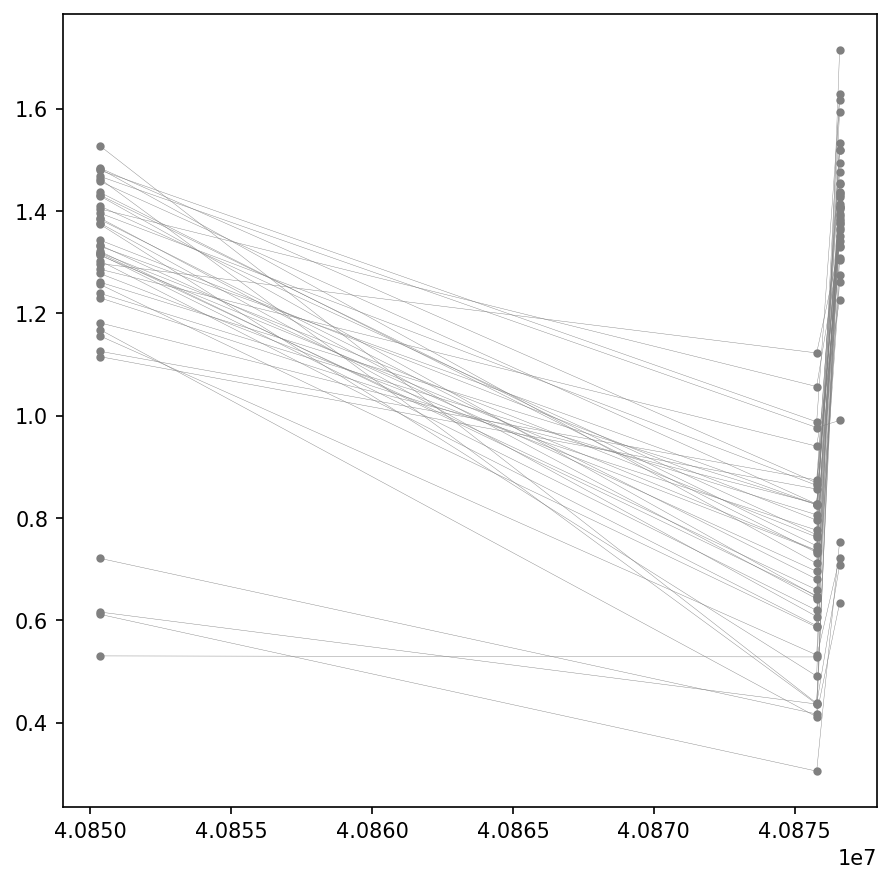

In [257]:
for index, row in cnv_data_df.iterrows(): 
#     row = next(cnv_data_df.iterrows())[1]
#     index = 1
    if index < 119:
        continue
    sampleID  = row[col_sampleID]
    cnv_chr   = row[col_cnv_chr]
    cnv_start = np.int(row[col_cnv_start])
    cnv_end   = np.int(row[col_cnv_end])
    cnv_type  = row[col_cnv_type]
    cnv_num_targets = row[col_cnv_num_targets]
    cnv_label  = row[col_cnv_label]
    cnv_canoes = str(row[col_cnv_canoes])
    cnv_xhmm   = str(row[col_cnv_xhmm])
    cnv_clamms = str(row[col_cnv_clamms])
    case_sample_color = color_del if cnv_type == 'DEL' else color_dup
    
    if cnv_label == 0:
        output_image_dir = output_false_image_dir
        output_image_splits_dir = output_false_image_splits_dir
    elif cnv_label == 1: 
        output_image_dir = output_true_image_dir
        output_image_splits_dir = output_true_image_splits_dir
    else:
        print("cnv_label error?", cnv_label)
        pdb.set_trace()
        
    cnv_label_str = "True" if cnv_label == 1 else "False"
    print("[%d|%d] Illustrating: %s %s:%d-%d %s #targets:%d Label:%s"% \
          (len(cnv_data_df), index+1, sampleID, cnv_chr, cnv_start, cnv_end, cnv_type, cnv_num_targets, cnv_label_str))

    ## Import RD data info
    print("  --Step1. Fetching %d capture windows based on CNV boundary ..."%len(RD_cnv_region))
    RD_cnv_region = fetchRDdata_byTabix(RD_norm_dir, sampleID, cnv_chr, cnv_start, cnv_end, target_group)
    
    ## Fetch Read depth data for reference samples in terms of CNV boundary       
    print("  --Step2. Fetching RD data for reference samples ...")
    ref_samples_file = ref_samples_dir+sampleID+'.ref.samples.txt.bz2'
    if not os.path.exists(ref_samples_file):
        print("    -[Error]: error in reference samples related file for %s in %s"%(sampleID, ref_samples_dir))
        #TODO: write to log file
        continue
    reference_RD_df = fetchRefRDdata_byTabix(ref_samples_file, cnv_chr, cnv_start, cnv_end, target_group)
        
    ## plot whole cnv
    print("  --Step3. Illustrating an image for the whole CNV ...")
    title_info = sampleID+" "+str(cnv_chr)+":"+str(cnv_start)+"-"+str(cnv_end)+" "+cnv_type +" "+ str((cnv_end-cnv_start)/1000) + 'kb'+ \
                " #targets:"+str(cnv_num_targets) + " #wins:" + str(len(RD_cnv_region)) + "\nCANOES:"+cnv_canoes + " XHMM:"+cnv_xhmm + " CLAMMS:"+cnv_clamms
    image_file = str(index+1)+"_"+sampleID+"_"+str(cnv_chr)+"_"+str(cnv_start)+"_"+str(cnv_end)+"_"+cnv_type+ "_"+str(cnv_num_targets)+"tgs_"+str(len(RD_cnv_region)) +"wins.png"
    fig = plt.figure(dpi=150,figsize=(10, 7)) 
    ax_rd = fig.subplots(nrows=1, ncols=1)
    ### plot reference samples
    for sample_reader in reference_RD_df["sample"].unique():
                ref_sample_df = reference_RD_df[reference_RD_df["sample"]==sample_reader]
                ax_rd.plot((ref_sample_df["start"]+ref_sample_df["end"])/2, ref_sample_df["RD_norm"], color='grey', marker='.', linewidth=0.2)
    ### plot case sample
    ax_rd.plot((RD_cnv_region["start"]+RD_cnv_region["end"])/2, RD_cnv_region["RD_norm"],color=case_sample_color , marker='o', linewidth=2)
    ax_rd.set_title(title_info)
    plt.savefig(output_image_dir+image_file)
    plt.close() 
    
    ## plot split CNV for each three targets
    print("  --Step4. Illustrating images for the CNV splited by each %d windows ..."%target_group)
    for group_id in np.unique(RD_cnv_region['target_group']):
        ## if targets equal to required number (3 by default)
        if len(RD_cnv_region[RD_cnv_region['target_group']==group_id]) == target_group:
            title_split_info = title_info +" Group:"+ str(int(len(RD_cnv_region)/target_group))+"-"+ str(group_id)
            image_split_file = str(index+1)+"_"+sampleID+"_"+str(cnv_chr)+"_"+str(cnv_start)+"_"+str(cnv_end)+"_"+cnv_type+ "_"+str(cnv_num_targets)+ \
                                "tgs_"+str(len(RD_cnv_region)) +"wins_splits"+str(int(len(RD_cnv_region)/target_group))+"_"+ str(group_id) +".png"
            fig = plt.figure(dpi=150,figsize=(7, 7)) 
            ax_rd = fig.subplots(nrows=1, ncols=1)

            RD_cnv_region_split = RD_cnv_region[RD_cnv_region["target_group"]==group_id]
            reference_RD_df_split = reference_RD_df[reference_RD_df["target_group"]==group_id]
            # plot reference samples
            for sample_reader in reference_RD_df_split["sample"].unique():
                ref_sample_df = reference_RD_df_split[reference_RD_df_split["sample"]==sample_reader]
                ax_rd.plot((ref_sample_df["start"]+ref_sample_df["end"])/2, ref_sample_df["RD_norm"], color = 'grey', marker='.', linewidth=0.2)
            # plot case sample
            ax_rd.plot((RD_cnv_region_split["start"]+RD_cnv_region_split["end"])/2, RD_cnv_region_split["RD_norm"], color=case_sample_color, marker='o', linewidth=2)
            ax_rd.set_title(title_split_info)
            plt.savefig(output_image_splits_dir+image_split_file)
            plt.close()

In [259]:
!jupyter nbconvert --to script generate_images.ipynb

[NbConvertApp] Converting notebook generate_images.ipynb to script
[NbConvertApp] Writing 14221 bytes to generate_images.py


In [16]:
## Seaborn version
# for index, row in cnv_data_df.iterrows(): 
#     if index > 1:
#         break
#     sampleID  = row[col_sampleID]
#     cnv_chr   = row[col_cnv_chr]
#     cnv_start = np.int(row[col_cnv_start])
#     cnv_end   = np.int(row[col_cnv_end])
#     cnv_type  = row[col_cnv_type]
#     cnv_num_targets = row[col_cnv_num_targets]
#     cnv_label = row[col_cnv_label]
#     if cnv_label == 0:
#         output_image_dir = output_false_image_dir
#     elif cnv_label == 1: 
#         output_image_dir = output_true_image_dir
#     else:
#         print("cnv_label error?", cnv_label)
#         pdb.set_trace()
        
#     print("Illustrating: ", index+1,"_____", sampleID, cnv_chr, cnv_start, cnv_end, cnv_type,cnv_num_targets)
    
#     ## Import RD data info
#     RD_norm_data = loadNormRD(RD_norm_dir, sampleID)
#     print("[Step1] Loaded normalized RD for %s, there are %d #windows of RD signal."%(sampleID, len(RD_norm_data)))

#     ## Fetch Read depth data for case sample in terms of CNV boundary
#     RD_cnv_region = fetchRDdata(RD_norm_data, cnv_chr, cnv_start, cnv_end, target_group)
#     print("[Step2] Fetched %d capture windows based on CNV boundary."%len(RD_cnv_region))
    
#     ## Fetch Read depth data for reference samples in terms of CNV boundary
#     reference_RD_df = fetchRefRDdata(ref_samples_dir, sampleID, cnv_chr, cnv_start, cnv_end, target_group)
#     print("[Step3] Fetched RD data for reference samples.")

#     ## Generate images
#     title_info = sampleID+" "+str(cnv_chr)+":"+str(cnv_start)+"-"+str(cnv_end)+" "+cnv_type+ " #targets:"+str(cnv_num_targets)
#     image_file = str(index+1)+"_"+sampleID+"_"+str(cnv_chr)+"_"+str(cnv_start)+"_"+str(cnv_end)+"_"+cnv_type+ "_"+str(cnv_num_targets)+"tgs.png"
#     plt.figure(dpi=200,figsize=(10, 7)) 
#     sns.set_theme(style="darkgrid")
#     sns.lineplot(data=reference_RD_df, x=(reference_RD_df["start"]+reference_RD_df["end"])/2, 
#                  y="RD_norm", units="sample",color=".7", estimator=None, marker='.', linewidth=1)
#     sns.lineplot(data=RD_cnv_region, x=(RD_cnv_region["start"]+RD_cnv_region["end"])/2, 
#                  y="RD_norm", marker='o', linewidth=2).set_title(title_info)
#     plt.savefig(output_image_dir+image_file)
#     print(title_info)
#     plt.close()
#     print("______________________________________________________")